# Imports

In [17]:
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Import the binary classification dataset
data = pd.read_csv('../../DataAnalysis/RandomForest/ebay_data_rf.csv', index_col=False)
data.drop('value', axis=1, inplace=True)

# Separate the target and inputs
y = data.sellingState
X = data.drop('sellingState', axis=1)

# Dependence of OOB error on n_estimators

The "out-of-bag" (OOB) error can be calculated while training a random forest, and gives a reasonable measure of the model validity. 

The 'n_estimators' parameter specifies the number of trees in the random forest. In general, larger numbers of trees improve the accuracy of the model, but increasing 'n_estimators' gives diminishing returns at a certain point. Large 'n_estimators' increases the training time and prediction time of the model, which we would like to avoid since ultimately our model will be exposed via an interactive web app.

## Calculate the OOB error rates

In [18]:
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for paralellised ensembles but is necessary for tracking the OOB
# error trajectory during training.
RANDOM_STATE = 123
ensemble_clfs = [
    ("RandomForestClassifier, max_features=5",
        RandomForestClassifier(warm_start=True,
                               max_features="sqrt",
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=7",
        RandomForestClassifier(warm_start=True,
                               max_features=7,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=21",
        RandomForestClassifier(warm_start=True,
                               max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 40
max_estimators = 140

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

## Generate the "OOB error rate" vs. "n_estimators" plot.

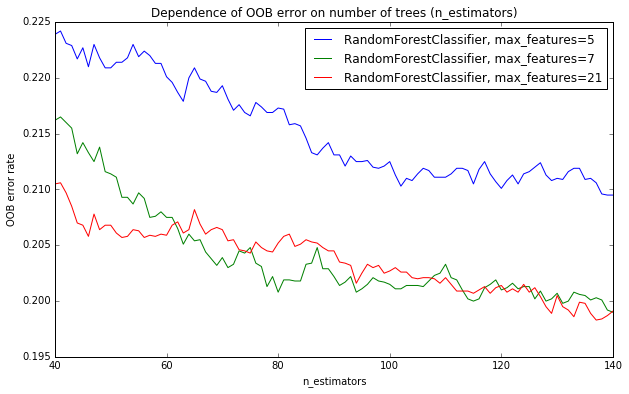

In [19]:
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.title("Dependence of OOB error on number of trees (n_estimators)")
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")

plt.show()

The 'max_features' parameter specifies the number of features to consider at each split in a decision tree in the random forest. Apparently, the data has more than 5 predictive features. For 'max_features' = 7, the OOB error rate settels down by about 'n_estimators' = 80.

# Dependence of OOB errors on "max_features"

We now determine the optimum value of 'max_features' for 'n_estimators' = 80.

## Calculate the OOB error rates

In [28]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='Variable'",
        RandomForestClassifier(n_estimators = 80,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_par = 1
max_par = 21

for label, clf in ensemble_clfs:
    for i in range(min_par, max_par + 1):
        clf.set_params(max_features=i)
        clf.fit(X, y)

        # Record the OOB error for each `max_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

## Generate the "OOB error rate" vs. "n_estimators" plot.

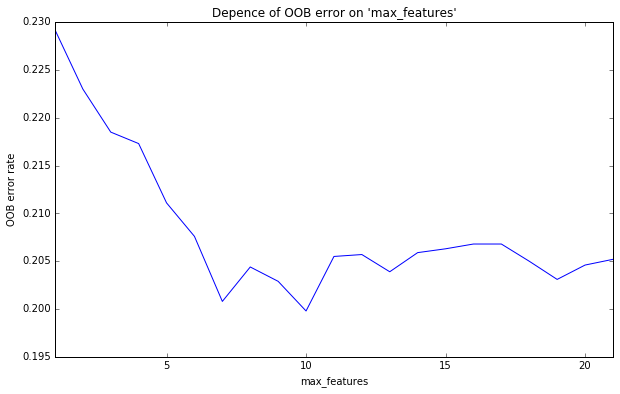

In [29]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.title("Depence of OOB error on 'max_features'")
plt.xlim(min_par, max_par)
plt.xlabel("max_features")
plt.ylabel("OOB error rate")

plt.show()

The plot shows the OOB error rate as a function of 'max_features' for max features from 1 to 21. 21 is the total number of features in our data set. The obvious candidates based on the plot are 'max_features' = 7 and 'max_features' = 10. Out of a preference for simpler models, we will use 'max_features' = 7.

# Summary
We considered the dependence of the OOB error rate for a random forest classification model on the random forest model parameters 'n_estimators' and 'max_features'. We found that that 'n_estimators' = 80 and 'max_features' = 7 was a reasonable choice of model parameters.